[![ebac_logo-data_science.png](https://raw.githubusercontent.com/earapanos/DataScienceExcercises/refs/heads/main/ebac_logo-data_science.png)](https://github.com/earapanos/DataScienceExcercises/tree/main)
<!-- <img src="https://raw.githubusercontent.com/earapanos/DataScienceExcercises/refs/heads/main/ebac_logo-data_science.png" alt="ebac_logo-data_science"> -->

---

<!-- # **Profiss√£o: Cientista de Dados** -->
### **M√≥dulo 38** | Streamlit IV e Pycaret | Exerc√≠cio 1

**Aluno:** [Eduardo Adriani Rapanos](https://www.linkedin.com/in/eduardo-rapanos/)<br>
**Data:** 25 de maio de 2025.

---

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cart√£o de cr√©dito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from scipy.stats import ks_2samp
from pycaret.classification import *

In [3]:
df = pd.read_feather(r'C:\Users\earap\Documents\EBAC\DataScienceExcercises\M√≥dulo_38_-_Streamlit_IV_e_Pycaret\credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empres√°rio                M√©dio     Solteiro            Casa     43   
1  Assalariado                M√©dio       Casado            Casa     35   
2  Assalariado                M√©dio       Casado            Casa     31   
3  Assalariado                M√©dio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os tr√™s √∫ltimos meses como safras de valida√ß√£o *out of time* (oot).

Vari√°veis:<br>
Considere que a vari√°vel ```data_ref``` n√£o √© uma vari√°vel explicativa, √© somente uma vari√°vel indicadora da safra, e n√£o deve ser utilizada na modelagem. A vari√°vei ```index``` √© um identificador do cliente, e tamb√©m n√£o deve ser utilizada como covari√°vel (vari√°vel explicativa). As restantes podem ser utilizadas para prever a inadimpl√™ncia, incluindo a renda.


In [4]:
# Converter data_ref para datetime e extrair m√™s/ano
df['data_ref'] = pd.to_datetime(df['data_ref'])
df['mes_ano'] = df['data_ref'].dt.to_period('M')

In [5]:
# Identificar os √∫ltimos 3 meses para valida√ß√£o OOT
ultimos_meses = df['mes_ano'].unique()[-3:]
print("Meses para valida√ß√£o OOT:", ultimos_meses)

Meses para valida√ß√£o OOT: <PeriodArray>
['2016-01', '2016-02', '2016-03']
Length: 3, dtype: period[M]


In [6]:
# Separar bases
df_oot = df[df['mes_ano'].isin(ultimos_meses)]
df_dev = df[~df['mes_ano'].isin(ultimos_meses)]

print(f"Base de desenvolvimento: {df_dev.shape[0]} linhas")
print(f"Base OOT: {df_oot.shape[0]} linhas")

Base de desenvolvimento: 600000 linhas
Base OOT: 150000 linhas


## Descritiva b√°sica univariada

- Descreva a base quanto ao n√∫mero de linhas, n√∫mero de linhas para cada m√™s em ```data_ref```.
- Fa√ßa uma descritiva b√°sica univariada de cada vari√°vel. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Descritiva b√°sica da base
print("\nN√∫mero de linhas totais:", df.shape[0])
print("\nContagem por m√™s:")
print(df['mes_ano'].value_counts().sort_index())


N√∫mero de linhas totais: 750000

Contagem por m√™s:
mes_ano
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64


In [8]:
# Vari√°veis qualitativas e quantitativas
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                'educacao', 'estado_civil', 'tipo_residencia']
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 
                'renda', 'mau']

In [9]:
# Descritiva qualitativas
print("\nDescritiva qualitativas:")
for var in qualitativas:
    print(f"\n{var}:")
    print(df[var].value_counts(normalize=True))


Descritiva qualitativas:

sexo:
sexo
F    0.672773
M    0.327227
Name: proportion, dtype: float64

posse_de_veiculo:
posse_de_veiculo
N    0.610605
S    0.389395
Name: proportion, dtype: float64

posse_de_imovel:
posse_de_imovel
S    0.671589
N    0.328411
Name: proportion, dtype: float64

tipo_renda:
tipo_renda
Assalariado         0.514320
Empres√°rio          0.230283
Pensionista         0.168353
Servidor p√∫blico    0.086563
Bolsista            0.000481
Name: proportion, dtype: float64

educacao:
educacao
M√©dio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
P√≥s gradua√ß√£o          0.001083
Name: proportion, dtype: float64

estado_civil:
estado_civil
Casado      0.701963
Solteiro    0.122212
Uni√£o       0.076913
Separado    0.056761
Vi√∫vo       0.042151
Name: proportion, dtype: float64

tipo_residencia:
tipo_residencia
Casa             0.899059
Com os pais      0.044309
Governamental    0.031253
Aluguel 

In [10]:
# Descritiva quantitativas
print("\nDescritiva quantitativas:")
print(df[quantitativas].describe())


Descritiva quantitativas:
          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  


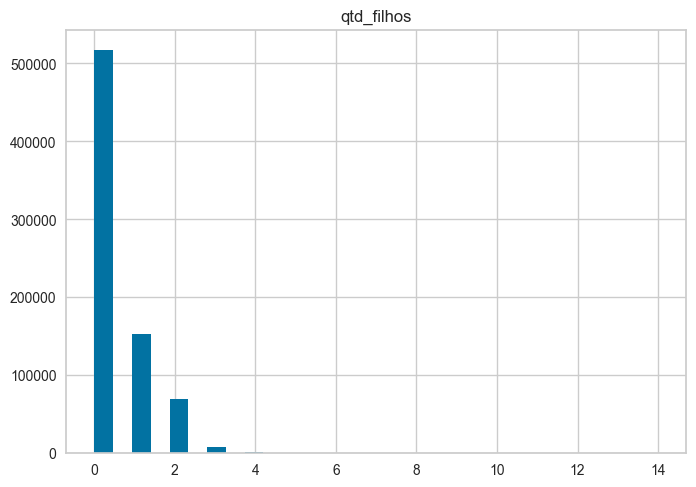

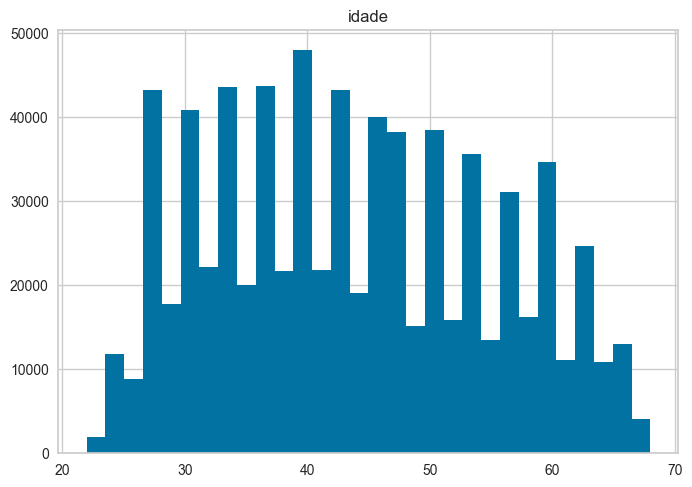

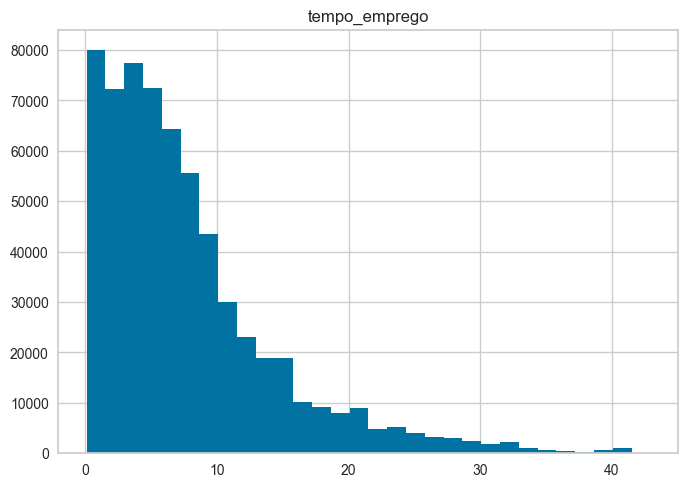

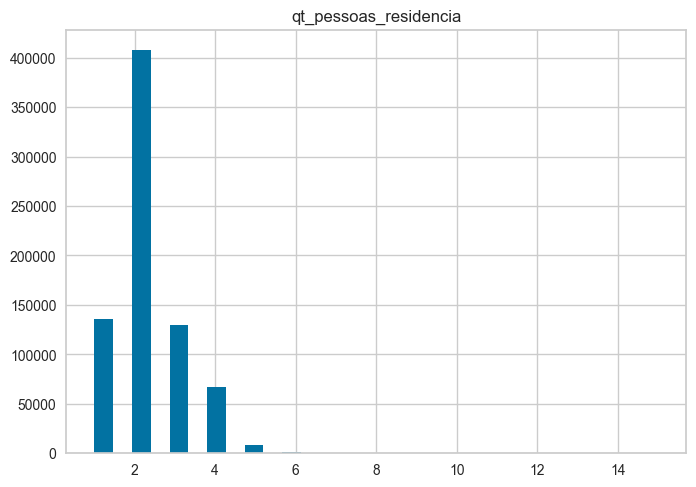

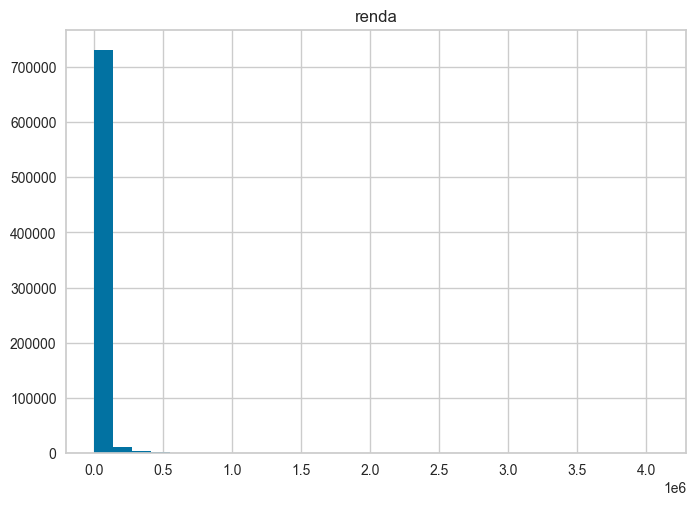

In [11]:
# Histogramas para vari√°veis quantitativas
for var in quantitativas:
    if var != 'mau':  # mau √© nossa target bin√°ria
        plt.figure()
        df[var].hist(bins=30)
        plt.title(var)
        plt.show()

## Descritiva bivariada

Fa√ßa uma an√°lise descritiva bivariada de cada vari√°vel

In [12]:
# An√°lise bivariada com a target 'mau'
print("\nRela√ß√£o com a vari√°vel target 'mau':")


Rela√ß√£o com a vari√°vel target 'mau':


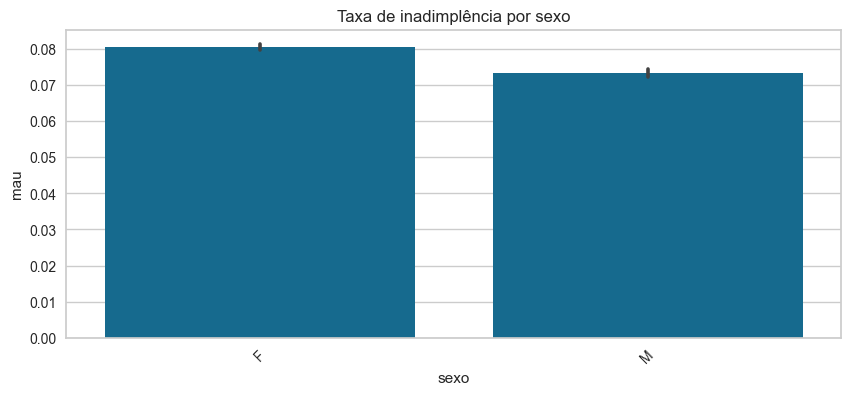

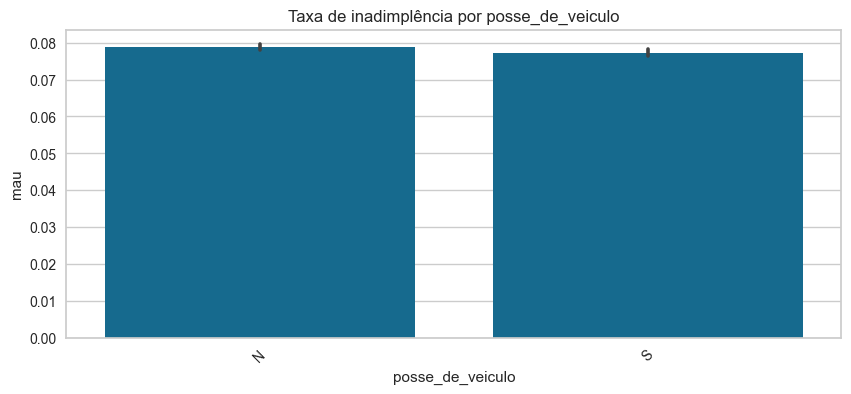

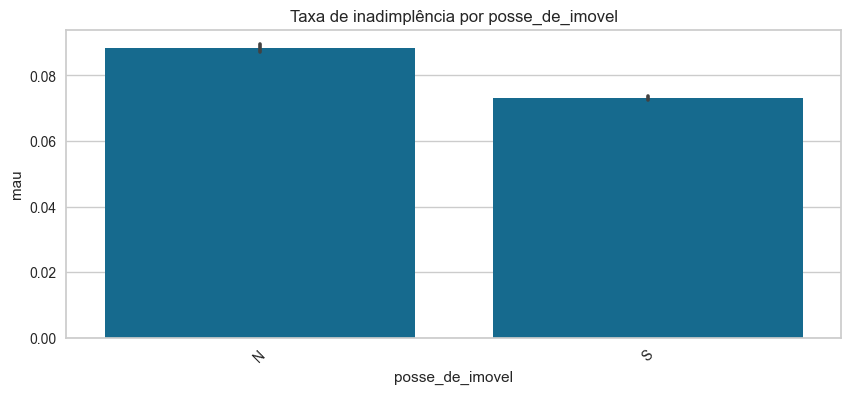

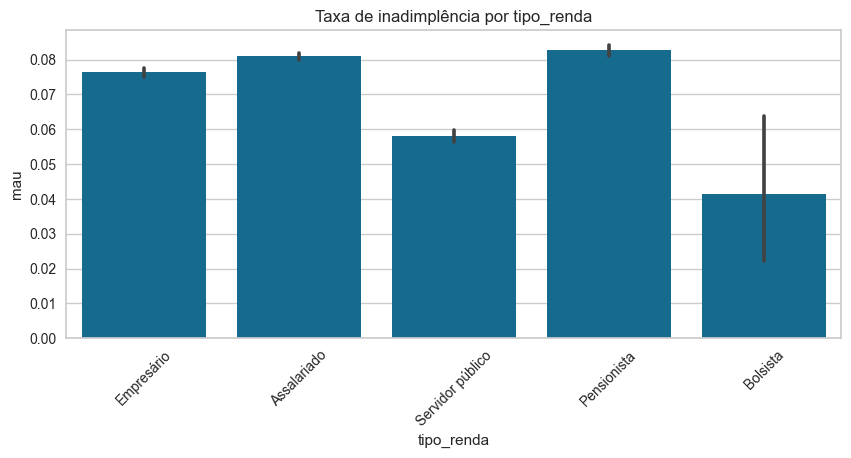

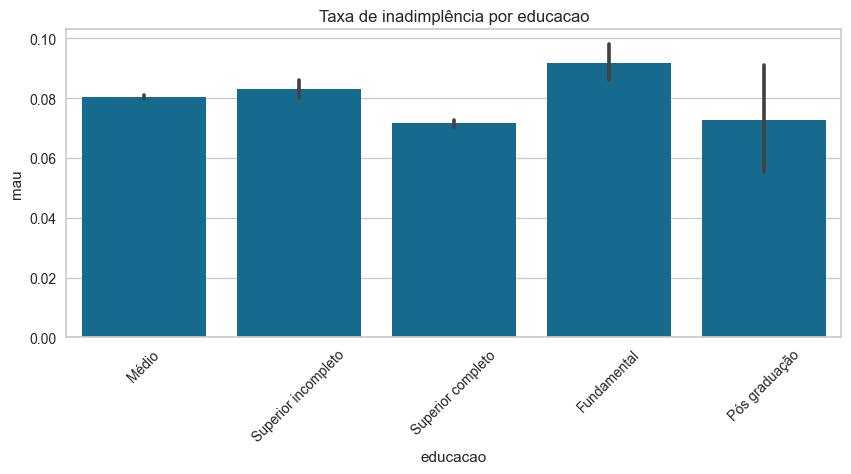

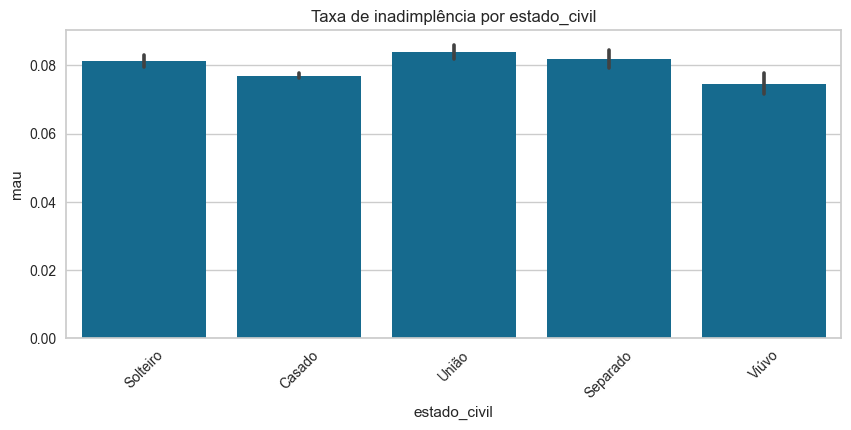

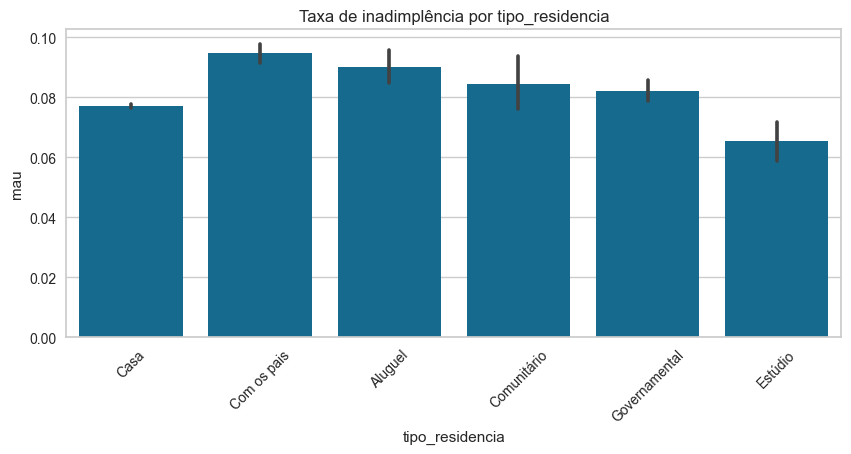

In [13]:
# Para qualitativas
for var in qualitativas:
    plt.figure(figsize=(10,4))
    sns.barplot(x=var, y='mau', data=df)
    plt.title(f'Taxa de inadimpl√™ncia por {var}')
    plt.xticks(rotation=45)
    plt.show()

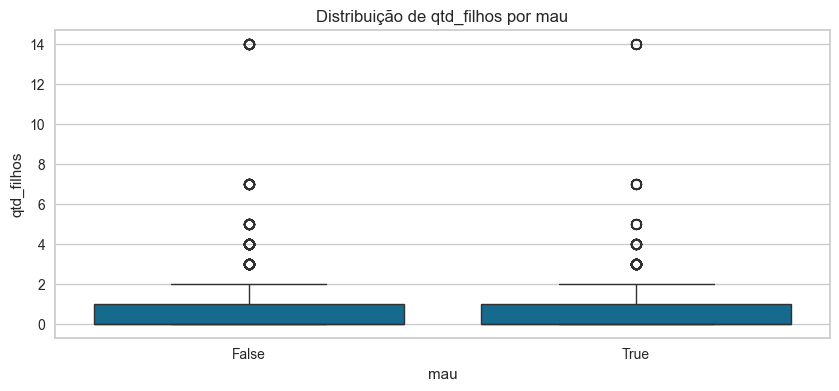

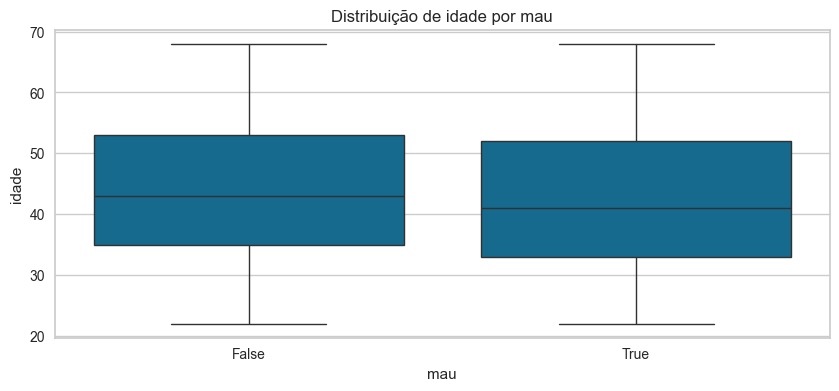

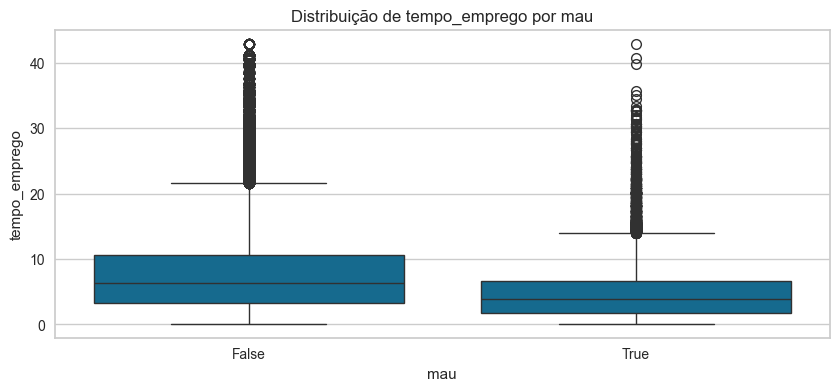

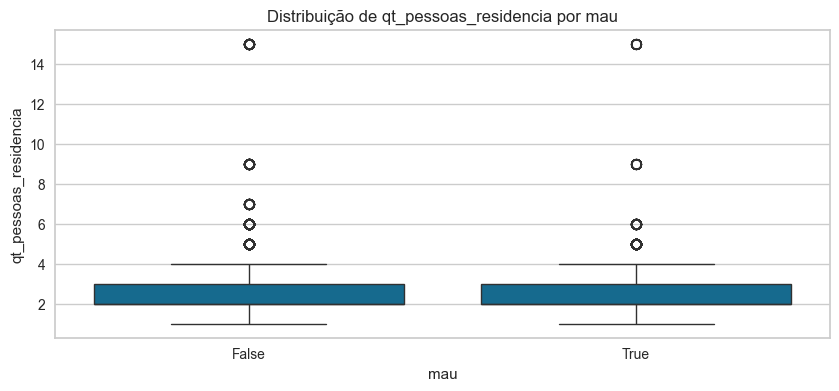

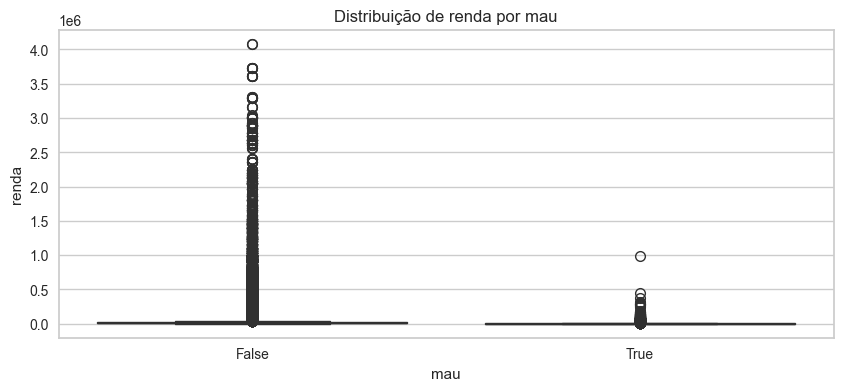

In [14]:
# Para quantitativas
for var in quantitativas:
    if var != 'mau':
        plt.figure(figsize=(10,4))
        sns.boxplot(x='mau', y=var, data=df)
        plt.title(f'Distribui√ß√£o de {var} por mau')
        plt.show()

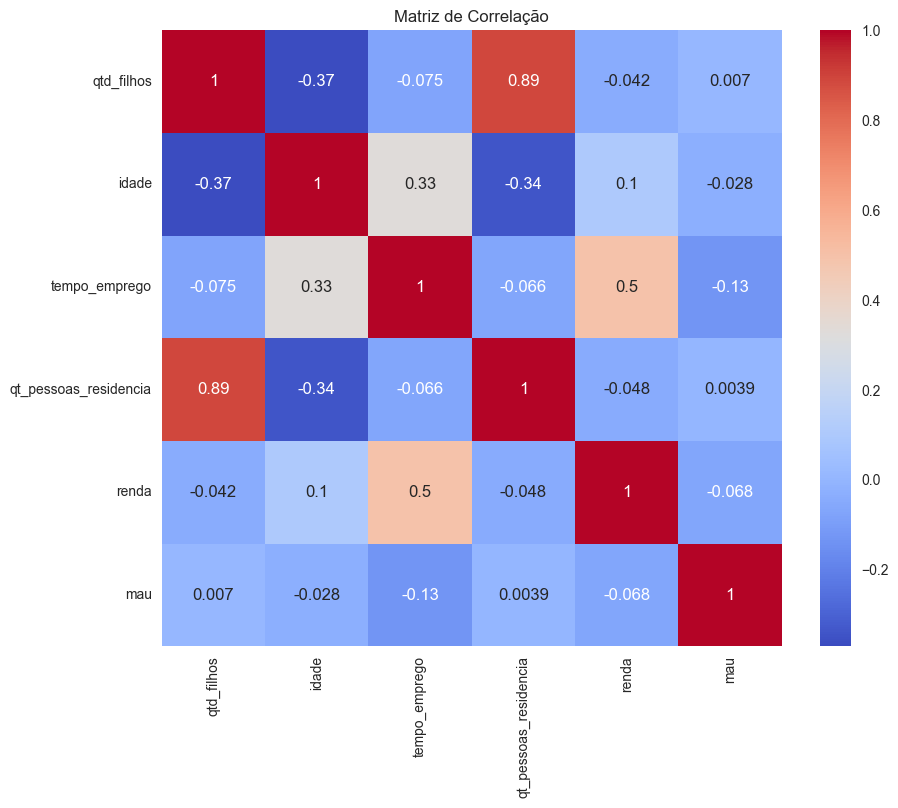

In [15]:
# Matriz de correla√ß√£o
corr = df[quantitativas].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correla√ß√£o')
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* atrav√©s de uma regress√£o log√≠stica.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Fa√ßa agrupamentos de categorias conforme vimos em aula
- Proponha uma equa√ß√£o preditiva para 'mau'
- Caso hajam categorias n√£o significantes, justifique

In [16]:
# Tratamento de missings - vamos preencher tempo_emprego com a mediana
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [17]:
# Tratamento de outliers - vamos capar renda no percentil 99
renda_cap = df['renda'].quantile(0.99)
df['renda'] = df['renda'].apply(lambda x: renda_cap if x > renda_cap else x)

In [18]:
# Agrupamento de categorias com poucas observa√ß√µes
df['educacao'] = df['educacao'].replace({
    'Superior incompleto': 'Superior',
    'Superior completo': 'Superior',
    'P√≥s gradua√ß√£o': 'Superior'
})

df['tipo_residencia'] = df['tipo_residencia'].replace({
    'Est√∫dio': 'Outros',
    'Com os pais': 'Outros',
    'Aluguel': 'Outros',
    'Casa': 'Casa/Pr√≥pria',
    'Pr√≥pria': 'Casa/Pr√≥pria'
})


In [19]:
# Sele√ß√£o de vari√°veis finais
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 
            'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
            'educacao', 'estado_civil', 'tipo_residencia']
target = 'mau'

In [20]:
# Separar em treino e teste na base de desenvolvimento
X_dev = df_dev[features]
y_dev = df_dev[target]
X_oot = df_oot[features]
y_oot = df_oot[target]

X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.3, random_state=42)

In [21]:
# Pipeline de pr√©-processamento
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'educacao', 'estado_civil', 'tipo_residencia']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [22]:
# Pipeline completo com PCA e Regress√£o Log√≠stica
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression(max_iter=1000))])

In [23]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'educacao', 'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('classifier', LogisticRegression(max_iter=1000))])

## Avalia√ß√£o do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acur√°cia, KS e Gini.

Avalie estas m√©tricas nas bases de desenvolvimento e *out of time*.

In [24]:
# Avaliar o modelo
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]
    
    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    
    # C√°lculo do KS
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    ks = max(tpr - fpr)
    
    print(f"\nAvalia√ß√£o para {dataset_name}:")
    print(f"Acur√°cia: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"KS: {ks:.4f}")
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend()
    plt.show()
    
    return acc, auc, ks


Desempenho do Modelo de Regress√£o Log√≠stica:

Avalia√ß√£o para Treino:
Acur√°cia: 0.9396
AUC: 0.6878
KS: 0.2777


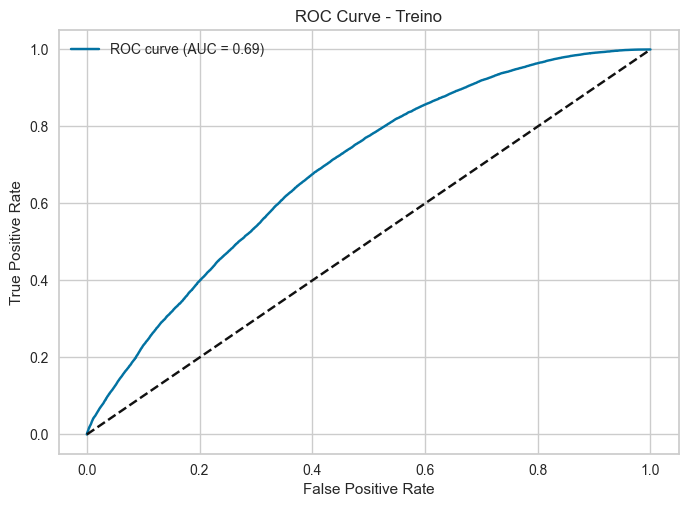


Avalia√ß√£o para Teste:
Acur√°cia: 0.9373
AUC: 0.6853
KS: 0.2736


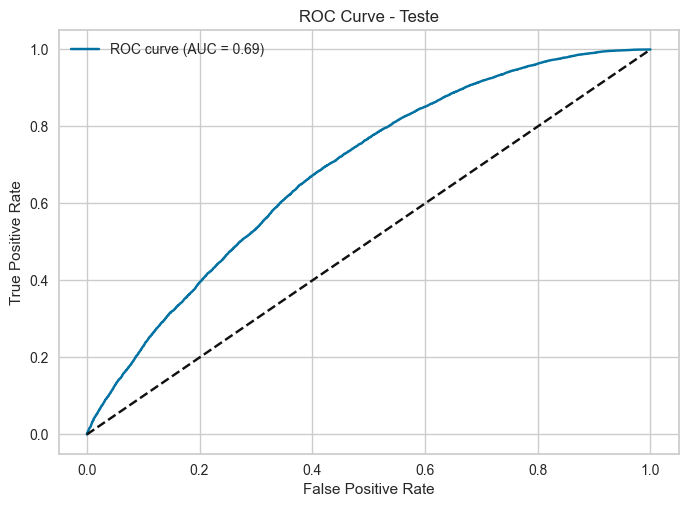


Avalia√ß√£o para OOT:
Acur√°cia: 0.8533
AUC: 0.6573
KS: 0.2267


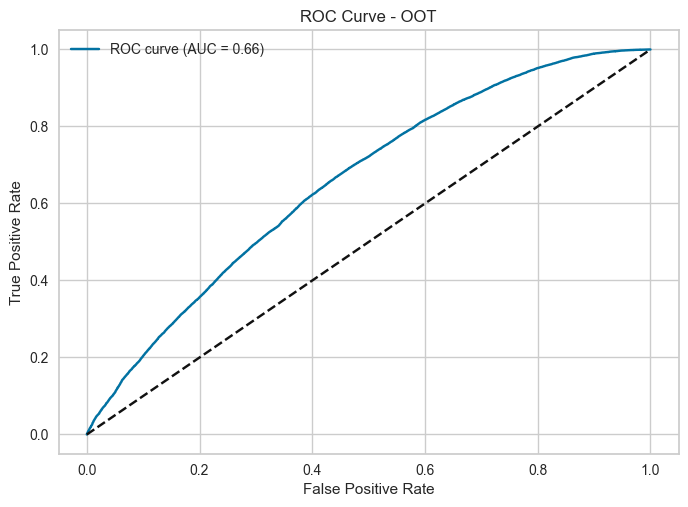

In [25]:
# Avaliar nas bases de treino, teste e OOT
print("\nDesempenho do Modelo de Regress√£o Log√≠stica:")
acc_train, auc_train, ks_train = evaluate_model(pipeline, X_train, y_train, "Treino")
acc_test, auc_test, ks_test = evaluate_model(pipeline, X_test, y_test, "Teste")
acc_oot, auc_oot, ks_oot = evaluate_model(pipeline, X_oot, y_oot, "OOT")

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [26]:
# Carregar os dados
df = pd.read_feather('credit_scoring.ftr')
print("Dados carregados com sucesso!")
df.head()

Dados carregados com sucesso!


data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empres√°rio                M√©dio     Solteiro            Casa     43   
1  Assalariado                M√©dio       Casado            Casa     35   
2  Assalariado                M√©dio       Casado            Casa     31   
3  Assalariado                M√©dio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Pr√© processamento

### Substitui√ß√£o de nulos (nans)

Existe nulos na base? √© dado num√©rico ou categ√≥rico? qual o valor de substitui√ß√£o? m√©dia? valor mais frequente? etc

In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import time

# Configura√ß√£o inicial
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Carregamento e An√°lise Inicial de Dados
def load_and_analyze_data():
    """Carrega e analisa os dados de forma otimizada"""
    # Tipos otimizados para economia de mem√≥ria
    dtype = {
        'qtd_filhos': 'int8',
        'idade': 'int16',
        'tempo_emprego': 'float32',
        'qt_pessoas_residencia': 'int8',
        'renda': 'float32',
        'mau': 'bool'
    }
    
    # Carregar dados
    df = pd.read_feather('credit_scoring.ftr').astype(dtype)
    
    # An√°lise inicial
    print("\nüîç An√°lise Inicial:")
    print(f"Total de linhas: {len(df)}")
    print(f"Propor√ß√£o de 'mau': {df['mau'].mean():.2%}")
    print("\nValores nulos por coluna:")
    print(df.isnull().sum())
    
    return df

df = load_and_analyze_data()

## 2. Pr√©-processamento Adaptado
# Definir vari√°veis
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                       'educacao', 'estado_civil', 'tipo_residencia']
target = 'mau'

# Tratamento de outliers otimizado
class SmartOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method='iqr', threshold=1.5):
        self.method = method
        self.threshold = threshold
        
    def fit(self, X, y=None):
        if self.method == 'iqr':
            self.q1_ = X[numeric_features].quantile(0.25)
            self.q3_ = X[numeric_features].quantile(0.75)
            self.iqr_ = self.q3_ - self.q1_
        else:  # z-score
            self.mean_ = X[numeric_features].mean()
            self.std_ = X[numeric_features].std()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in numeric_features:
            if self.method == 'iqr':
                lower = self.q1_[col] - self.threshold * self.iqr_[col]
                upper = self.q3_[col] + self.threshold * self.iqr_[col]
            else:  # z-score
                lower = self.mean_[col] - self.threshold * self.std_[col]
                upper = self.mean_[col] + self.threshold * self.std_[col]
            
            mask = (X_copy[col] < lower) | (X_copy[col] > upper)
            X_copy.loc[mask, col] = np.nan
        return X_copy

# Pipeline num√©rico adaptado
numeric_transformer = Pipeline(steps=[
    ('outlier', SmartOutlierHandler(method='iqr')),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline categ√≥rico adaptado
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pr√©-processador completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    n_jobs=-1)

## 3. Modelagem e Avalia√ß√£o
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """Fun√ß√£o para treinar e avaliar modelos"""
    start_time = time.time()
    print(f"\nTreinando {model.__class__.__name__}...")
    
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Avalia√ß√£o
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n‚è± Tempo de treinamento: {train_time:.2f} segundos")
    print("\nüìä Relat√≥rio de Classifica√ß√£o:")
    print(classification_report(y_test, y_pred))
    
    print("\nüìà M√©tricas Adicionais:")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Matriz de confus√£o formatada
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, 
                        index=['Real Bom', 'Real Mau'], 
                        columns=['Predito Bom', 'Predito Mau'])
    print("\nüéØ Matriz de Confus√£o:")
    print(cm_df)
    
    return model

## 4. Pipeline Principal
def create_main_pipeline():
    return Pipeline([
        ('preprocessor', preprocessor),
        ('dim_reduction', PCA(n_components=0.95)),  # Mant√©m 95% da vari√¢ncia
        ('classifier', RandomForestClassifier(
            n_estimators=150,
            max_depth=12,
            min_samples_split=10,
            n_jobs=-1,
            random_state=42,
            class_weight='balanced'  # Importante para dados desbalanceados
        ))
    ])

# Vers√£o LightGBM (recomendada)
def create_lightgbm_pipeline():
    from lightgbm import LGBMClassifier
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=7,
            n_jobs=-1,
            random_state=42,
            is_unbalance=True
        ))
    ])

## 5. Execu√ß√£o Principal
# Prepara√ß√£o dos dados
X = df[numeric_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("\nüî¢ Distribui√ß√£o das classes:")
print(y_train.value_counts(normalize=True))

# Treinar e avaliar modelos
print("\n" + "="*50)
print("üöÄ Modelo RandomForest")
print("="*50)
rf_model = create_main_pipeline()
rf_model = train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)

print("\n" + "="*50)
print("üí° Modelo LightGBM (Recomendado)")
print("="*50)
lgbm_model = create_lightgbm_pipeline()
lgbm_model = train_and_evaluate(lgbm_model, X_train, y_train, X_test, y_test)

## 6. Feature Importance (Opcional)
def plot_feature_importance(model, feature_names, top_n=20):
    """Visualiza a import√¢ncia das features"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importance = model.named_steps['classifier'].feature_importances_
    else:
        print("Modelo n√£o suporta feature_importances_")
        return
    
    # Obter nomes das features ap√≥s one-hot encoding
    if hasattr(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
        cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        all_features = numeric_features + list(cat_features)
    else:
        all_features = feature_names
    
    # Criar DataFrame com import√¢ncias
    feat_imp = pd.DataFrame({
        'Feature': all_features,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp)
    plt.title(f'Top {top_n} Features por Import√¢ncia')
    plt.show()

# Visualizar import√¢ncia (para RandomForest)
def plot_feature_importance(model, feature_names, top_n=20):
    """Visualiza a import√¢ncia das features corrigida"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    try:
        # Obter import√¢ncias do modelo
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importance = model.named_steps['classifier'].feature_importances_
        else:
            print("Modelo n√£o suporta feature_importances_")
            return
        
        # Obter nomes das features ap√≥s transforma√ß√£o
        preprocessor = model.named_steps['preprocessor']
        
        # Features num√©ricas (mant√™m seus nomes)
        num_features = numeric_features
        
        # Features categ√≥ricas (one-hot encoded)
        if hasattr(preprocessor.named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
            cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        else:
            # Fallback para vers√µes mais antigas
            cat_features = []
            for i, col in enumerate(categorical_features):
                cats = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i]
                for cat in cats:
                    cat_features.append(f"{col}_{cat}")
        
        all_features = list(num_features) + list(cat_features)
        
        # Verificar compatibilidade de tamanhos
        if len(importance) != len(all_features):
            print(f"Aviso: N√∫mero de import√¢ncias ({len(importance)}) diferente do n√∫mero de features ({len(all_features)})")
            print("Usando apenas as primeiras features correspondentes...")
            min_length = min(len(importance), len(all_features))
            importance = importance[:min_length]
            all_features = all_features[:min_length]
        
        # Criar DataFrame com import√¢ncias
        feat_imp = pd.DataFrame({
            'Feature': all_features,
            'Importance': importance
        }).sort_values('Importance', ascending=False).head(top_n)
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp)
        plt.title(f'Top {top_n} Features por Import√¢ncia')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Erro ao plotar import√¢ncia das features: {str(e)}")


üîç An√°lise Inicial:
Total de linhas: 750000
Propor√ß√£o de 'mau': 7.82%

Valores nulos por coluna:
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

üî¢ Distribui√ß√£o das classes:
mau
False    0.92181
True     0.07819
Name: proportion, dtype: float64

üöÄ Modelo RandomForest

Treinando Pipeline...

‚è± Tempo de treinamento: 80.71 segundos

üìä Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

       False       0.96      0.70      0.81    207407
        True       0.17      0.69      0.27     17593

    acc

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Fa√ßa todos os passos a passos da aula e gere os gr√°ficos finais. E o pipeline de toda a transforma√ß√£o.



In [28]:
from pycaret.classification import *
import pandas as pd

In [29]:
from pycaret.classification import *
import pandas as pd

# 1. Carregar e preparar os dados
df = pd.read_feather('credit_scoring.ftr')
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 
            'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
            'educacao', 'estado_civil', 'tipo_residencia', 'mau']
df = df[features]

# 2. Configura√ß√£o universal do ambiente
try:
    # Tentativa para vers√µes mais recentes (3.0+)
    setup_args = {
        'data': df,
        'target': 'mau',
        'train_size': 0.7,
        'normalize': True,
        'transformation': True,
        'fix_imbalance': True,
        'session_id': 42,
        'verbose': False,
        'low_variance_threshold': 0.9,  # Novo nome do par√¢metro
        'remove_multicollinearity': True,
        'multicollinearity_threshold': 0.9
    }
    
    # Verificar e remover par√¢metros n√£o suportados
    import inspect
    setup_params = inspect.signature(setup).parameters
    for key in list(setup_args.keys()):
        if key not in setup_params:
            del setup_args[key]
    
    clf = setup(**setup_args)

except Exception as e:
    # Fallback para vers√µes mais antigas
    print(f"Usando configura√ß√£o alternativa: {str(e)}")
    clf = setup(data=df, 
                target='mau',
                train_size=0.7,
                silent=True,  # Equivalente a verbose=False em vers√µes antigas
                normalize=True,
                transformation=True,
                ignore_low_variance=True,  # Nome antigo do par√¢metro
                remove_multicollinearity=True,
                multicollinearity_threshold=0.9,
                fix_imbalance=True,
                session_id=42)

# 3. Modelagem com LightGBM
lgbm = create_model('lightgbm', cross_validation=True)

# 4. Otimiza√ß√£o do modelo
tuned_lgbm = tune_model(lgbm, optimize='AUC')

# 5. Avalia√ß√£o final
evaluate_model(tuned_lgbm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin‚Ä¶